## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [67]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/parser_data.csv")
df = df.drop(columns="Unnamed: 0")
df 

,tik_name,uik_name,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна
0,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,345,120
1,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,326,46
2,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,332,96
3,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,171,71
4,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,266,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,Территориальная избирательная комиссия №30,УИК №2350,284,300,166,53,81,53,166,0,219,0,0,21,184,14
2017,Территориальная избирательная комиссия №30,УИК №2351,132,150,86,27,37,27,86,2,111,0,0,7,91,13
2018,Территориальная избирательная комиссия №30,УИК №2352,320,350,217,23,110,23,217,4,236,0,0,20,193,23
2019,Территориальная избирательная комиссия №30,УИК №2355,485,500,335,12,153,12,335,2,345,0,0,23,290,32


In [68]:
#явка (%) по всем ТИК, результат отсортировать по убыванию

df["Суммарно биллютеней"] = df["Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования"] + df["Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования"]
df["Явка"] = df["Суммарно биллютеней"] / df["Число избирателей, внесенных в список избирателей на момент окончания голосования"]
df.sort_values("Явка", ascending=False, inplace=True)
df.head()

,tik_name,uik_name,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Суммарно биллютеней,Явка
972,Территориальная избирательная комиссия №15,УИК №2293,203,300,151,52,97,52,151,10,193,0,0,20,142,31,203,1.0
1458,Территориальная избирательная комиссия №22,УИК №408,201,500,120,81,299,81,120,9,192,0,0,17,140,35,201,1.0
1095,Территориальная избирательная комиссия №17,УИК №2284,235,500,235,0,265,0,235,11,224,0,0,17,165,42,235,1.0
1377,Территориальная избирательная комиссия №21,УИК №2343,76,200,63,13,124,13,63,1,75,0,0,8,64,3,76,1.0
1969,Территориальная избирательная комиссия №29,УИК №2178,126,500,126,0,374,0,126,0,126,0,0,12,114,0,126,1.0


In [69]:
#Лучщий участок Тихоновой

df["Тих. проц"] = -1
df.loc[df["Суммарно биллютеней"] >= 100, "Тих. проц"] = np.around(df["Тихонова Надежда Геннадьевна"] / df["Суммарно биллютеней"], 2)
df.iloc[df["Тих. проц"].argmax()].uik_name


'УИК №2283'

In [70]:
#найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

(df.groupby("tik_name")["Явка"].max() - df.groupby("tik_name")["Явка"].min()).sort_values().index[-1]

'Территориальная избирательная комиссия №17'

In [71]:
#посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

df.groupby("tik_name")["Явка"].var().sort_values()

tik_name
Территориальная избирательная комиссия №25    0.000844
Территориальная избирательная комиссия №6     0.002043
Территориальная избирательная комиссия №14    0.003146
Территориальная избирательная комиссия №12    0.003220
Территориальная избирательная комиссия №7     0.006799
Территориальная избирательная комиссия №3     0.007303
Территориальная избирательная комиссия №10    0.007428
Территориальная избирательная комиссия №16    0.011306
Территориальная избирательная комиссия №9     0.011464
Территориальная избирательная комиссия №5     0.013666
Территориальная избирательная комиссия №20    0.017360
Территориальная избирательная комиссия №1     0.019176
Территориальная избирательная комиссия №19    0.020498
Территориальная избирательная комиссия №27    0.020655
Территориальная избирательная комиссия №26    0.022018
Территориальная избирательная комиссия №4     0.022297
Территориальная избирательная комиссия №18    0.024045
Территориальная избирательная комиссия №11    0.024049
Т

In [72]:
# для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) 
# - количество УИК, на которых кандидат получил данный результат


In [73]:
df["Бег. проц"] = -1
df.loc[df["Суммарно биллютеней"] >= 100, "Бег. проц"] = np.around(df["Беглов Александр Дмитриевич"] / df["Суммарно биллютеней"], 2)


In [74]:
df["Амос. проц"] = -1
df.loc[df["Суммарно биллютеней"] >= 100, "Амос. проц"] = np.around(df["Амосов Михаил Иванович"] / df["Суммарно биллютеней"], 2)


In [75]:
counts = df.groupby("Тих. проц").count()["uik_name"]
print("Тихонова Надежда Геннадьевна")
for percent, count in zip(counts.index, counts):
    print(f"{percent}: {count}")

Тихонова Надежда Геннадьевна
-1.0: 15
0.0: 1
0.01: 4
0.02: 5
0.03: 11
0.04: 8
0.05: 14
0.06: 21
0.07: 22
0.08: 35
0.09: 43
0.1: 46
0.11: 51
0.12: 67
0.13: 77
0.14: 116
0.15: 143
0.16: 216
0.17: 187
0.18: 186
0.19: 203
0.2: 151
0.21: 117
0.22: 97
0.23: 58
0.24: 28
0.25: 21
0.26: 20
0.27: 9
0.28: 9
0.29: 8
0.3: 3
0.31: 8
0.32: 2
0.33: 5
0.34: 1
0.35: 5
0.36: 2
0.37: 1
0.38: 1
0.4: 1
0.41: 1
0.44: 1
0.48: 1


In [76]:
counts = df.groupby("Бег. проц").count()["uik_name"]
print("Беглов Александр Дмитриевич")
for percent, count in zip(counts.index, counts):
    print(f"{percent}: {count}")

Беглов Александр Дмитриевич
-1.0: 15
0.3: 1
0.32: 1
0.33: 2
0.38: 3
0.39: 3
0.4: 3
0.41: 5
0.42: 3
0.43: 3
0.44: 8
0.45: 8
0.46: 10
0.47: 20
0.48: 14
0.49: 24
0.5: 27
0.51: 37
0.52: 37
0.53: 44
0.54: 36
0.55: 52
0.56: 62
0.57: 68
0.58: 77
0.59: 79
0.6: 122
0.61: 93
0.62: 92
0.63: 96
0.64: 89
0.65: 79
0.66: 82
0.67: 73
0.68: 77
0.69: 61
0.7: 72
0.71: 48
0.72: 53
0.73: 40
0.74: 37
0.75: 37
0.76: 28
0.77: 21
0.78: 19
0.79: 20
0.8: 20
0.81: 24
0.82: 13
0.83: 14
0.84: 14
0.85: 9
0.86: 7
0.87: 7
0.88: 5
0.89: 5
0.9: 6
0.91: 6
0.92: 2
0.93: 1
0.94: 3
0.95: 1
0.96: 1
0.98: 2


In [77]:
counts = df.groupby("Амос. проц").count()["uik_name"]
print("Амосов Михаил Иванович")
for percent, count in zip(counts.index, counts):
    print(f"{percent}: {count}")

Амосов Михаил Иванович
-1.0: 15
0.01: 6
0.02: 6
0.03: 2
0.04: 13
0.05: 17
0.06: 23
0.07: 35
0.08: 47
0.09: 68
0.1: 89
0.11: 98
0.12: 116
0.13: 130
0.14: 129
0.15: 160
0.16: 153
0.17: 151
0.18: 126
0.19: 100
0.2: 89
0.21: 82
0.22: 76
0.23: 44
0.24: 56
0.25: 40
0.26: 44
0.27: 26
0.28: 26
0.29: 17
0.3: 15
0.31: 5
0.32: 6
0.33: 4
0.34: 1
0.35: 3
0.36: 2
0.42: 1


In [78]:
#визуализируйте отношение - явка на УИК  →  результат кандидата.

import matplotlib.pyplot as plt

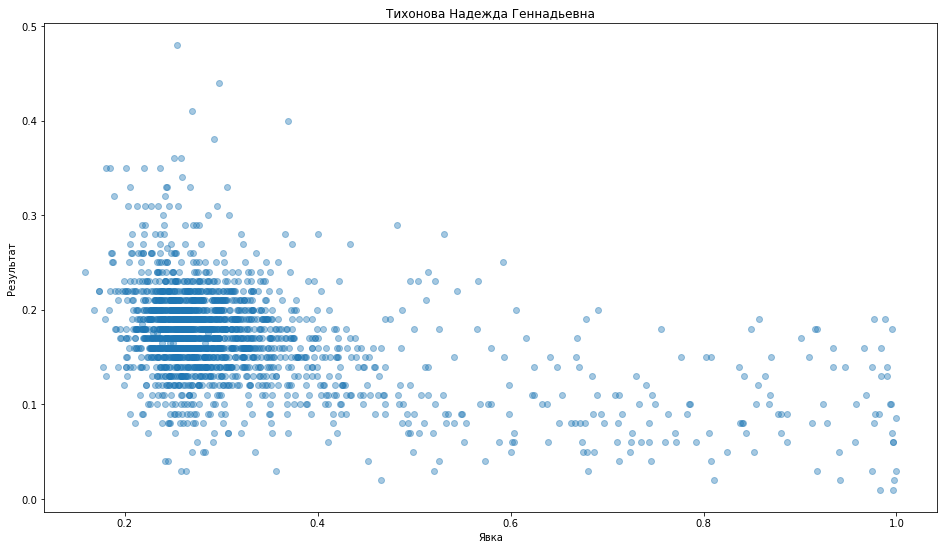

In [79]:
buf = df.loc[df["Тих. проц"] != -1].groupby("Явка")["Тих. проц"].mean()

x = buf.index
y = buf.values

plt.figure(figsize=(16, 9))
plt.scatter(x, y, alpha=0.4)
plt.xlabel("Явка")
plt.ylabel("Результат")
plt.title("Тихонова Надежда Геннадьевна")
plt.show()

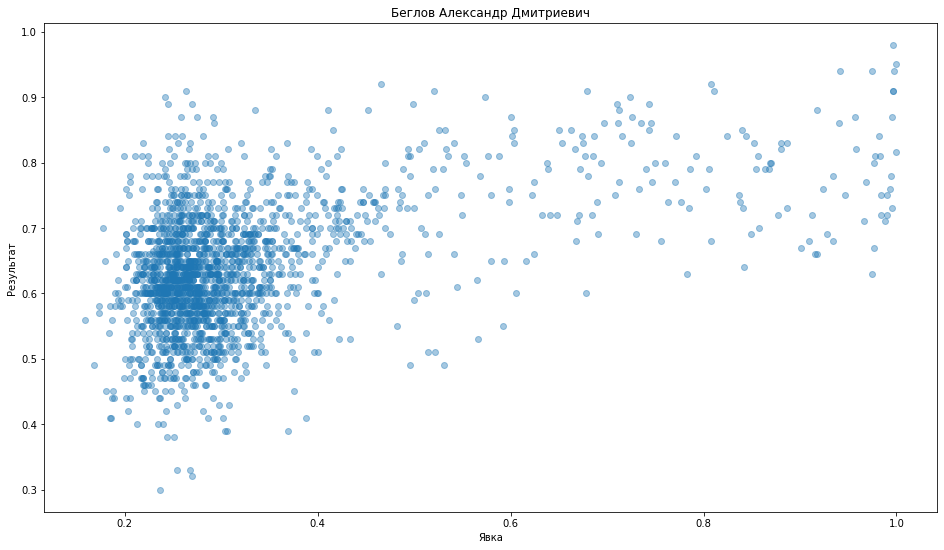

In [80]:
buf = df.loc[df["Бег. проц"] != -1].groupby("Явка")["Бег. проц"].mean()

x = buf.index
y = buf.values

plt.figure(figsize=(16, 9))
plt.scatter(x, y, alpha=0.4)
plt.xlabel("Явка")
plt.ylabel("Результат")
plt.title("Беглов Александр Дмитриевич")
plt.show()

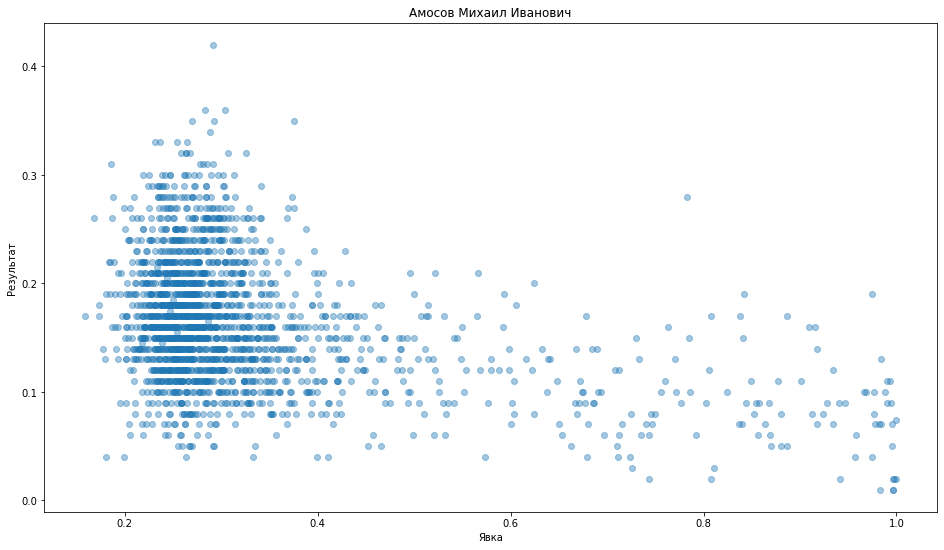

In [81]:
buf = df.loc[df["Амос. проц"] != -1].groupby("Явка")["Амос. проц"].mean()

x = buf.index
y = buf.values

plt.figure(figsize=(16, 9))
plt.scatter(x, y, alpha=0.4)
plt.xlabel("Явка")
plt.ylabel("Результат")
plt.title("Амосов Михаил Иванович")
plt.show()

In [82]:
df

,tik_name,uik_name,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,...,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Суммарно биллютеней,Явка,Тих. проц,Бег. проц,Амос. проц
972,Территориальная избирательная комиссия №15,УИК №2293,203,300,151,52,97,52,151,10,...,0,0,20,142,31,203,1.000000,0.15,0.70,0.10
1458,Территориальная избирательная комиссия №22,УИК №408,201,500,120,81,299,81,120,9,...,0,0,17,140,35,201,1.000000,0.17,0.70,0.08
1095,Территориальная избирательная комиссия №17,УИК №2284,235,500,235,0,265,0,235,11,...,0,0,17,165,42,235,1.000000,0.18,0.70,0.07
1377,Территориальная избирательная комиссия №21,УИК №2343,76,200,63,13,124,13,63,1,...,0,0,8,64,3,76,1.000000,-1.00,-1.00,-1.00
1969,Территориальная избирательная комиссия №29,УИК №2178,126,500,126,0,374,0,126,0,...,0,0,12,114,0,126,1.000000,0.00,0.90,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Территориальная избирательная комиссия №5,УИК №1424,1814,1700,320,1,1379,1,320,6,...,0,0,45,225,45,321,0.176957,0.14,0.70,0.14
475,Территориальная избирательная комиссия №6,УИК №1139,1848,1500,317,3,1180,3,317,10,...,0,0,53,186,71,320,0.173160,0.22,0.58,0.17
1756,Территориальная избирательная комиссия №26,УИК №1215,1959,2000,331,8,1661,8,331,9,...,0,0,62,194,74,339,0.173047,0.22,0.57,0.18
647,Территориальная избирательная комиссия №10,УИК №203,859,800,143,1,656,1,143,7,...,0,0,37,71,29,144,0.167637,0.20,0.49,0.26
